# Part 1. GARCH

In [1]:
# 0. Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# test Dickey-Fuller 
from statsmodels.tsa.stattools import adfuller

# for autocorrelation plot
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Box-Cox
from scipy.stats import boxcox  
from scipy.special import inv_boxcox 

# ARCH - autoregressive conditional heteroskedasticity
from arch import arch_model

from sklearn.svm import SVR

In [2]:
# 1. Init helper methods

# Dickey-Fuller Test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


# calls test_stationarity() and plot Autocorrelation and Quantil-Quantil graph
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    plt.clf()
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05) # автокорреляция
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05) # частичная автокорреляция
        sm.qqplot(y, line='s', ax=qq_ax) # график квантиль-квантиль
        
        plt.tight_layout()
        plt.show()
    return

<Figure size 640x480 with 0 Axes>

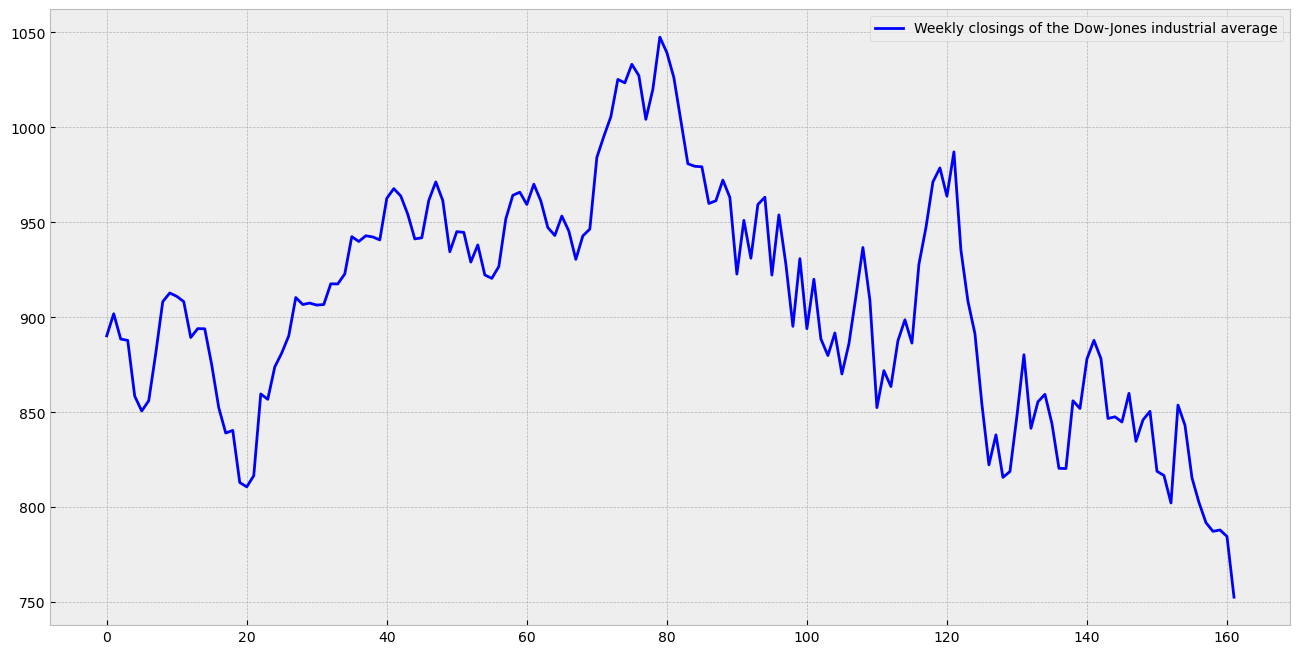

In [3]:
# 2. Init data
dowjones_closing = ("Datasets/weekly-closings-of-the-dowjones-.csv")
#mean_monthly_temp = pd.read_csv("Datasets/mean-monthly-air-temperature-deg.csv")
#robberies_in_boston = pd.read_csv("Datasets/monthly-boston-armed-robberies-j.csv")
#airlines_passengers  = pd.read_csv("Datasets/international-airline-passengers.csv")

all_series = {
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
#    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
#    "Monthly Boston armed robberies": robberies_in_boston["Count"],
#    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"]
}



with plt.style.context(style='bmh'):
    plt.clf()
    plt.figure(figsize=(16, 8))
    ax = plt.axes()
    plt.plot(dowjones_closing['Close'], color='blue', label='Weekly closings of the Dow-Jones industrial average') # original
    plt.legend()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


<Figure size 640x480 with 0 Axes>

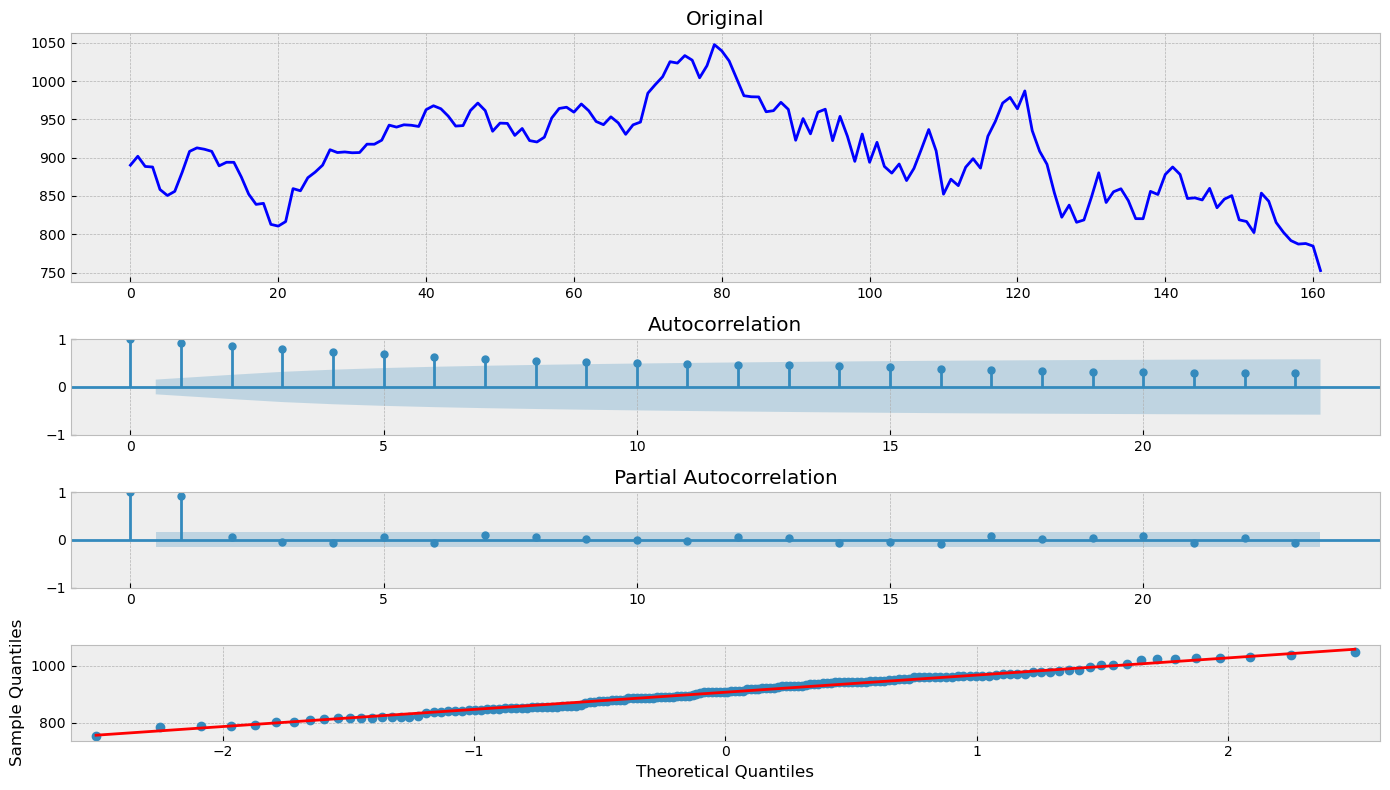

In [4]:
# 3. Plot the TM
tsplot(dowjones_closing['Close'])

# The time series isn't stationary because:

- The mean value and dispersion don't change over the time
- p-value > 0.5
- Autocorrelation doesn't fall quickly

However

- on the QQ graph blue points are almost on the red line


### Let's make this TM stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


<Figure size 640x480 with 0 Axes>

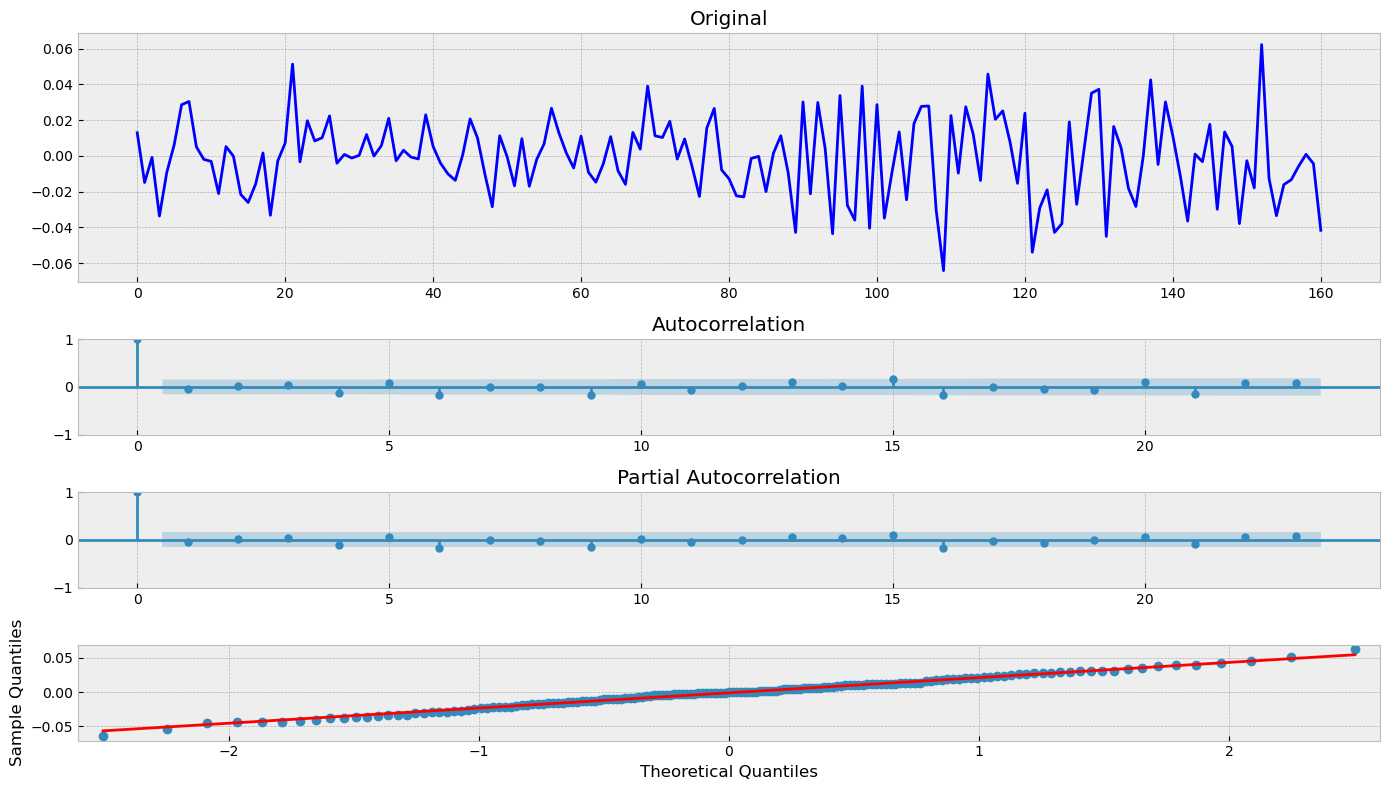

In [5]:
# 4. Box-Cox
series_boxcox = boxcox(dowjones_closing['Close'], 0)
# 5. Difference
ser_diff = np.diff(series_boxcox, 1)
tsplot(ser_diff)

### The graph has different variance.

In [6]:
# 6. Look for the best GARCH model
best_aic = np.inf 
best_order = None
best_mdl = None


def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(1, 5):
        for d in range(5):
            for j in range(5):
                #try:
                    tmp_mdl = arch_model(TS, p=i, o=d, q=j, dist='StudentsT').fit(update_freq=5, disp='off') 
                    #tmp_mdl = ARIMA(TS, order=(i, d, j)).fit(method='innovations_mle') # the parameters obtained with ARIMA can be applied to GARCH
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                #except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


aic, order, mdl = _get_best_model(ser_diff[:-5])

/Users/yevgeny/miniconda3/envs/ml/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/yevgeny/miniconda3/envs/ml/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/yevgeny/miniconda3/envs/ml/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/yevgeny/miniconda3/envs/ml/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_sls

aic: -757.83095 | order: (1, 3, 1)


/Users/yevgeny/miniconda3/envs/ml/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [7]:
# Get the GARCH model summary
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(ser_diff[:-5], p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     76,   Neg. LLF: 930.3334627071907
Iteration:     10,   Func. Count:    127,   Neg. LLF: 1144.5667578385364
Iteration:     15,   Func. Count:    177,   Neg. LLF: 870.9725477578452
Iteration:     20,   Func. Count:    227,   Neg. LLF: 53929.61837816144
Iteration:     25,   Func. Count:    289,   Neg. LLF: -352.34188456263905
Iteration:     30,   Func. Count:    340,   Neg. LLF: 526.6715300999596
Iteration:     35,   Func. Count:    390,   Neg. LLF: -172.0256315553308
Iteration:     40,   Func. Count:    440,   Neg. LLF: -364.25391426304964
Iteration:     45,   Func. Count:    489,   Neg. LLF: -378.53027418466775
Iteration:     50,   Func. Count:    537,   Neg. LLF: -384.0875265946994
Iteration:     55,   Func. Count:    585,   Neg. LLF: -386.2520085421848
Iteration:     60,   Func. Count:    630,   Neg. LLF: -386.76049355638315
Iteration:     65,   Func. Count:    675,   Neg. LLF: -386.91237676874493
Optimization terminated successfully    (Exit mode

#### There are fitted:
- omega, one alpha, four gammas and one beta coefficients 

In [8]:
# Get volatility forecast using GARCH
forecast = res.forecast(horizon=5, method='simulation')  # method='bootstrap'
volatility_forecast = forecast.variance
print("Volatility forecast:", np.array(volatility_forecast))

Volatility forecast: [[0.00053346 0.00076617 0.00071976 0.00069469 0.00070462]]


In [9]:
std_deviation_forecast = np.sqrt(np.array(volatility_forecast)[0])
print("Standard Deviation Forecast:", std_deviation_forecast)

Standard Deviation Forecast: [0.02309668 0.0276797  0.02682834 0.02635692 0.02654471]


In [10]:
last_price = np.array(dowjones_closing['Close'])[-6]
horizon = 5 
forecasted_volatility = np.array(volatility_forecast)[0] #std_deviation_forecast


scaled_volatility_forecast = last_price + 10000 * forecasted_volatility

print("Scaled Volatility forecast:", scaled_volatility_forecast)

Scaled Volatility forecast: [807.74456679 810.0716574  809.60759838 809.35687449 809.45621693]


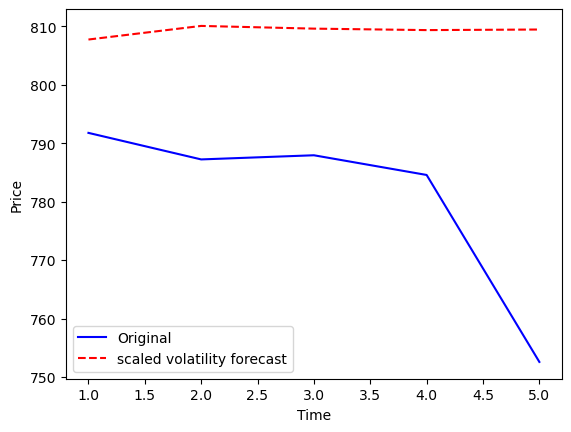

In [11]:

plt.plot(range(1, horizon + 1), np.array(dowjones_closing['Close'])[-5:], label='Original', color='blue')
plt.plot(range(1, horizon + 1), scaled_volatility_forecast, label='scaled volatility forecast', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#### GARCH models forecast volatility, not prices. High volatility indicates a higher potential for large price movements (either up or down).
#### For price forecasting, combine volatility forecasts with models for expected returns.

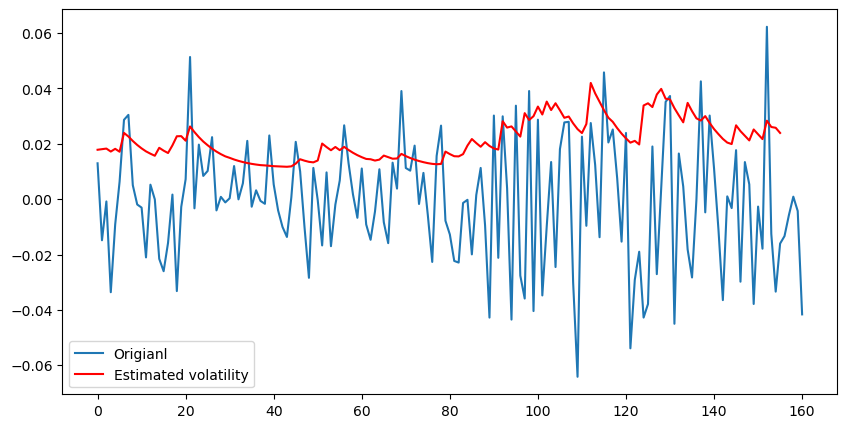

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(ser_diff, label='Origianl')
plt.plot(res.conditional_volatility, label='Estimated volatility', color='red')
plt.legend()
plt.show()

# Part 2. Forecast using classic ML

In [13]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    test_index = int(len(data)*(1-test_size))
    
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = prepareData(dowjones_closing, lag_start=1, lag_end=20, test_size=0.2)

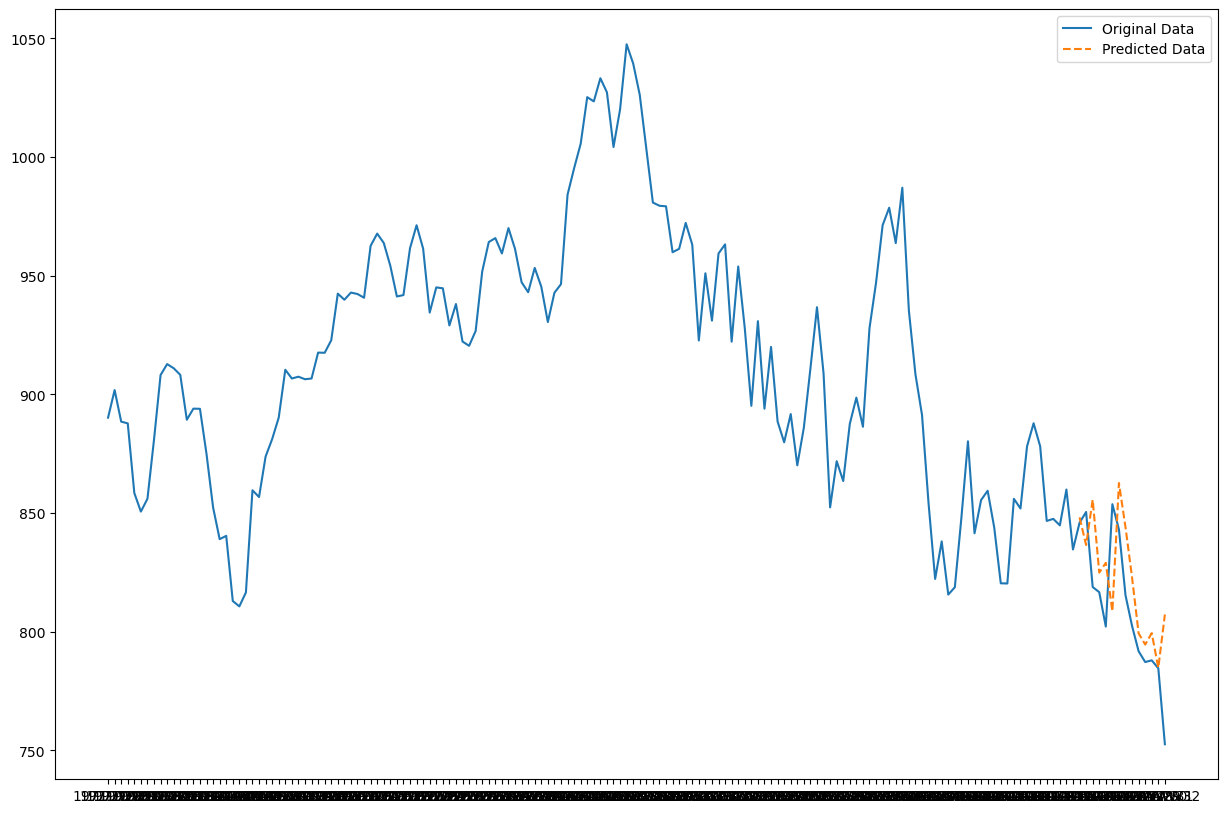

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit SVR
model = LinearRegression()
model.fit(X_train_poly, y_train)


# Get prediction
y_pred = model.predict(X_test_poly)

# Plot graphs
plt.figure(figsize=(15, 10))
plt.plot(dowjones_closing['Week'], dowjones_closing['Close'], label='Original Data')
plt.plot(dowjones_closing['Week'][-len(y_pred):], y_pred, label='Predicted Data', linestyle='--')
plt.legend()
plt.show()